# Cherry plossom
* we use 9 months
* may-dec (5-12) from previous year and january (1=13) from this year
* example: may-dec 2014 and jan 2015 are saved as months 5-13 in 2015

## imports

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor  # Use RandomForestClassifier for classification
from sklearn.metrics import mean_squared_error, r2_score

import seaborn as sns


In [2]:
import torch

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import _LRScheduler

In [3]:
if False:
    # Example: Generate some synthetic data
    np.random.seed(42)
    n_samples = 30
    n_features = 12

    # Create a DataFrame with random features
    input_features = pd.DataFrame(np.random.randn(n_samples, n_features), columns=[f'feature_{i}' for i in range(n_features)])
    # Generate a continuous target variable (for regression)

    doy_label = np.random.randn(n_samples) * 0.5



## read data

### oni

In [387]:
df_feature_ONI = pd.read_csv('../../datasets/csv/ONI_data.csv')
df_feature_ONI = df_feature_ONI.rename(columns={'Year': 'year'})

print("before")
print(df_feature_ONI.head())

# year before the blossom
df_after_amj = df_feature_ONI.iloc[:, 5:]   # From AMJ to NDJ (after AMJ)
df_after_amj.columns = ["ONI_" + col + '_prev' for col in df_after_amj.columns]
df_after_amj["year"] = df_feature_ONI["year"] + 1 # increment to become "this year"

# year of the blossom (month 13 = january of this year)
df_before_amj = df_feature_ONI.iloc[:, 1:2]  # From DJF
df_before_amj.columns = ["ONI_" + col for col in df_before_amj.columns]
df_before_amj["year"] = df_feature_ONI["year"]


df_feature_ONI = pd.merge(df_after_amj, df_before_amj, on='year', how='inner').dropna()

print("after")
print(df_feature_ONI.head())

before
   year  DJF  JFM  FMA  MAM  AMJ  MJJ  JJA  JAS  ASO  SON  OND  NDJ
0  1950 -1.5 -1.3 -1.2 -1.2 -1.1 -0.9 -0.5 -0.4 -0.4 -0.4 -0.6 -0.8
1  1951 -0.8 -0.5 -0.2  0.2  0.4  0.6  0.7  0.9  1.0  1.2  1.0  0.8
2  1952  0.5  0.4  0.3  0.3  0.2  0.0 -0.1  0.0  0.2  0.1  0.0  0.1
3  1953  0.4  0.6  0.6  0.7  0.8  0.8  0.7  0.7  0.8  0.8  0.8  0.8
4  1954  0.8  0.5  0.0 -0.4 -0.5 -0.5 -0.6 -0.8 -0.9 -0.8 -0.7 -0.7
after
   ONI_AMJ_prev  ONI_MJJ_prev  ONI_JJA_prev  ONI_JAS_prev  ONI_ASO_prev  \
0          -1.1          -0.9          -0.5          -0.4          -0.4   
1           0.4           0.6           0.7           0.9           1.0   
2           0.2           0.0          -0.1           0.0           0.2   
3           0.8           0.8           0.7           0.7           0.8   
4          -0.5          -0.5          -0.6          -0.8          -0.9   

   ONI_SON_prev  ONI_OND_prev  ONI_NDJ_prev  year  ONI_DJF  
0          -0.4          -0.6          -0.8  1951     -0.8  
1     

In [388]:
# Define a mapping of seasons to actual month numbers
season_to_month = {
    "AMJ_prev": 5, "MJJ_prev": 6, "JJA_prev": 7, "JAS_prev": 8, "ASO_prev": 9, 
    "SON_prev": 10, "OND_prev": 11, "NDJ_prev": 12, "DJF": 13
}


# Convert to long format
df_feature_ONI = df_feature_ONI.melt(id_vars=["year"], var_name="season", value_name="ONI")

# Extract season key (e.g., AMJ_prev, MJJ_prev, DJF)
df_feature_ONI["season_key"] = df_feature_ONI["season"].str.replace("ONI_", "")

# Map to actual months
df_feature_ONI["month"] = df_feature_ONI["season_key"].map(season_to_month)

# Create year-month column
df_feature_ONI["year_month"] = df_feature_ONI["year"].astype(str) + "_" + df_feature_ONI["month"].astype(str)

# Keep only required columns
df_feature_ONI = df_feature_ONI[["year_month", "year", "month", "ONI"]]

df_feature_ONI = df_feature_ONI.sort_values(["year", "month"])

df_feature_ONI.head()

,year_month,year,month,ONI
0,1951_5,1951,5,-1.1
73,1951_6,1951,6,-0.9
146,1951_7,1951,7,-0.5
219,1951_8,1951,8,-0.4
292,1951_9,1951,9,-0.4


### enso

In [389]:
df_feature_ENSO = pd.read_csv('../../datasets/csv/enso_data.csv')
df_feature_ENSO = df_feature_ENSO.rename(columns={'YR': 'year', 'MON': 'month'})
# YR 	MON 	TOTAL 	ClimAdjust 	ANOM

print("before")
print(df_feature_ENSO.head())

# prev year
#df_after_amj = df_feature_ENSO.iloc[:, 5:]   # From AMJ to NDJ (after AMJ)
#df_after_amj["year"] = df_feature_ENSO["year"] + 1  # increment to become "this year"

# this year
#df_before_amj = df_feature_ENSO.iloc[:, 1:2]  # From DJF
#df_before_amj["year"] = df_feature_ENSO["year"]

df_month_1 = df_feature_ENSO[df_feature_ENSO["month"] == 1].copy()
df_month_1["month"] = 13


# Filter months 5-12
df_month_5_12 = df_feature_ENSO[df_feature_ENSO["month"].between(5, 12)]
df_month_5_12["year"] += 1


df_feature_ENSO = pd.concat([df_month_5_12, df_month_1])

#df_feature_ENSO["year_month"] = df_feature_ENSO["year"].astype(str) + "_" + df_feature_ENSO["month"].astype(str)

df_feature_ENSO = df_feature_ENSO.sort_values(["year", "month"])

df_feature_ENSO["year_month"] = df_feature_ENSO["year"].astype(str) + "_" + df_feature_ENSO["month"].astype(str)


df_feature_ENSO = df_feature_ENSO.iloc[1:].reset_index(drop=True)

print("after")
print(df_feature_ENSO)

before
   year  month  TOTAL  ClimAdjust  ANOM
0  1950      1  24.56       26.18 -1.62
1  1950      2  25.07       26.39 -1.32
2  1950      3  25.88       26.95 -1.07
3  1950      4  26.29       27.39 -1.11
4  1950      5  26.19       27.56 -1.37
after
     year  month  TOTAL  ClimAdjust  ANOM year_month
0    1951      5  26.19       27.56 -1.37     1951_5
1    1951      6  26.47       27.21 -0.74     1951_6
2    1951      7  26.28       26.72 -0.44     1951_7
3    1951      8  25.88       26.30 -0.42     1951_8
4    1951      9  25.73       26.14 -0.41     1951_9
..    ...    ...    ...         ...   ...        ...
670  2025      9  26.46       26.72 -0.26     2025_9
671  2025     10  26.45       26.72 -0.27    2025_10
672  2025     11  26.46       26.70 -0.25    2025_11
673  2025     12  26.00       26.60 -0.60    2025_12
674  2025     13  25.79       26.55 -0.76    2025_13

[675 rows x 6 columns]


C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [390]:
df_feature_ENSO

,year,month,TOTAL,ClimAdjust,ANOM,year_month
0,1951,5,26.19,27.56,-1.37,1951_5
1,1951,6,26.47,27.21,-0.74,1951_6
2,1951,7,26.28,26.72,-0.44,1951_7
3,1951,8,25.88,26.30,-0.42,1951_8
4,1951,9,25.73,26.14,-0.41,1951_9
...,...,...,...,...,...,...
670,2025,9,26.46,26.72,-0.26,2025_9
671,2025,10,26.45,26.72,-0.27,2025_10
672,2025,11,26.46,26.70,-0.25,2025_11
673,2025,12,26.00,26.60,-0.60,2025_12


In [434]:
df_features = pd.merge(df_feature_ENSO, df_feature_ONI, on=['year_month', "year", "month"], how='inner').dropna()
df_features = df_features.drop(columns=["ANOM"])
df_features = df_features[df_features['year'].isin(df_features['year'].value_counts()[df_features['year'].value_counts() == 9].index)]
df_features

,year,month,TOTAL,ClimAdjust,year_month,ONI
0,1951,5,26.19,27.56,1951_5,-1.1
1,1951,6,26.47,27.21,1951_6,-0.9
2,1951,7,26.28,26.72,1951_7,-0.5
3,1951,8,25.88,26.30,1951_8,-0.4
4,1951,9,25.73,26.14,1951_9,-0.4
...,...,...,...,...,...,...
652,2023,9,25.65,26.72,2023_9,-1.0
653,2023,10,25.73,26.72,2023_10,-1.0
654,2023,11,25.80,26.70,2023_11,-0.9
655,2023,12,25.75,26.60,2023_12,-0.8


In [680]:
# Replace 'filename.csv' with the path to your CSV file
df_label = pd.read_csv('../../datasets/csv/cherry/doy_cherry_peak_bloom_Japan_Tsu.csv')

# Display the first few rows of the DataFrame
print(df_label.head())

   year  doy_cherry_peak_bloom
0  1953                    102
1  1954                     94
2  1955                     95
3  1956                    100
4  1957                    103


In [681]:
# Merge and remove rows with missing values
merged_df = pd.merge(df_label, df_features, on='year', how='inner').dropna()

# Split back into two DataFrames without 'ID'
df_label = merged_df[['doy_cherry_peak_bloom']]
df_features = merged_df.drop(columns=['doy_cherry_peak_bloom'])

In [682]:
df_label

,doy_cherry_peak_bloom
0,102
1,102
2,102
3,102
4,102
...,...
535,84
536,84
537,84
538,84


In [683]:
df_features.head()

,year,month,TOTAL,ClimAdjust,year_month,ONI
0,1953,5,27.79,27.56,1953_5,0.2
1,1953,6,27.18,27.21,1953_6,0.0
2,1953,7,26.52,26.72,1953_7,-0.1
3,1953,8,26.30,26.30,1953_8,0.0
4,1953,9,26.35,26.14,1953_9,0.2


## eda

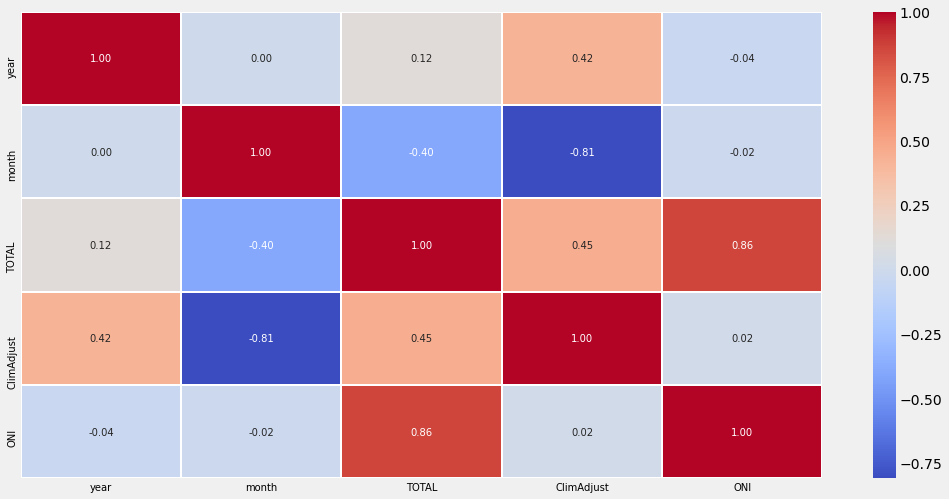

In [684]:
corr_matrix = df_features.corr(method='spearman')
f, ax = plt.subplots(figsize=(16,8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', linewidth=0.4,
            annot_kws={"size": 10}, cmap='coolwarm', ax=ax)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

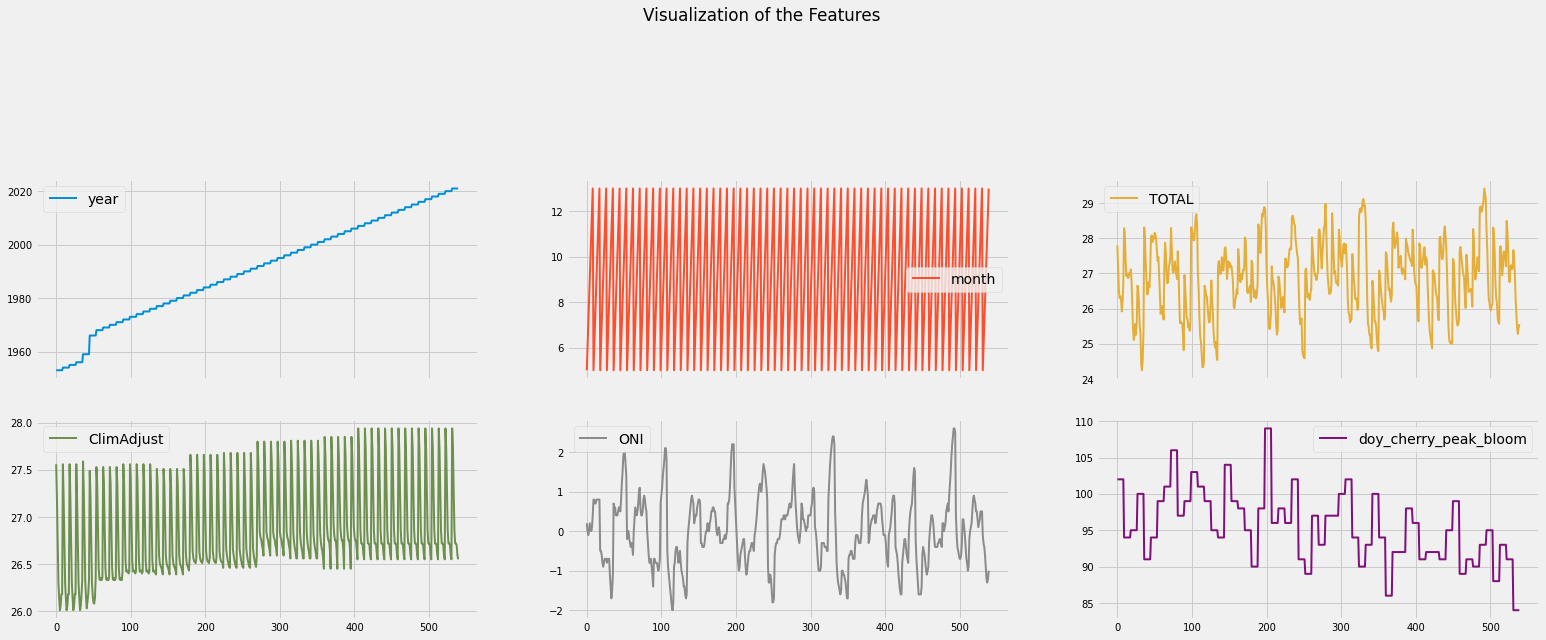

In [729]:
plt.style.use('fivethirtyeight')
pd.concat([df_features, df_label]).plot(subplots=True,
                  layout=(6, 3),
                  figsize=(24,24),
                  fontsize=10, 
                  linewidth=2, 
                  title='Visualization of the Features')
plt.show()

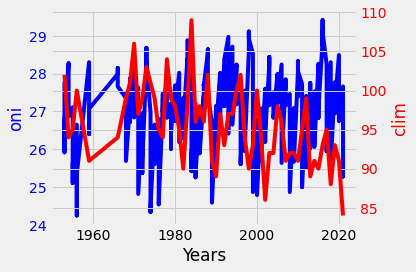

In [752]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax1 = plt.subplots()

# First plot
ax1.plot(df_features["year"], df_features["TOTAL"], 'b-', label="oni")
ax1.set_xlabel("Years")
ax1.set_ylabel("oni", color="b")
ax1.tick_params(axis='y', labelcolor="b")

# Second y-axis
#ax2 = ax1.twinx()
#ax2.plot(df_features["year"], df_label, 'r-', label="cherry")
#ax2.set_ylabel("cherry", color="r")
#ax2.tick_params(axis='y', labelcolor="r")

ax2 = ax1.twinx()
ax2.plot(df_features["year"], df_label["doy_cherry_peak_bloom"], 'r-', label="cherry")
ax2.set_ylabel("clim", color="r")
ax2.tick_params(axis='y', labelcolor="r")

fig.tight_layout()
plt.show()

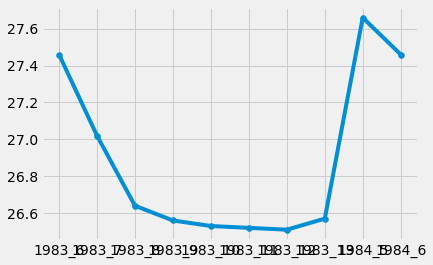

In [753]:
plt.scatter(df_features["year_month"][190:200], df_features["ClimAdjust"][190:200], label="cherry")
plt.plot(df_features["year_month"][190:200], df_features["ClimAdjust"][190:200], label="cherry")


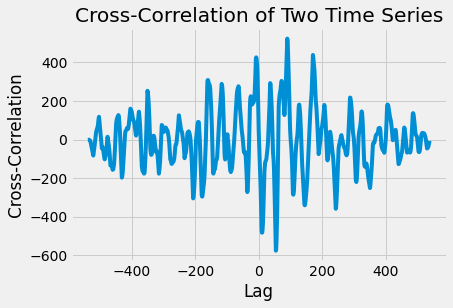

In [687]:
import numpy as np
import matplotlib.pyplot as plt

# Example time series
x = df_features["ONI"] # First signal
y = df_label["doy_cherry_peak_bloom"]  # Second signal

# Compute cross-correlation
corr = np.correlate(x - np.mean(x), y - np.mean(y), mode="full")

# Lag values
lags = np.arange(-len(x) + 1, len(x))

# Plot
plt.plot(lags, corr)
plt.xlabel("Lag")
plt.ylabel("Cross-Correlation")
plt.title("Cross-Correlation of Two Time Series")
plt.show()

## split data (RUN THIS!!!)

In [688]:
input_features = df_features# .drop(columns=["year"])
doy_label = df_label["doy_cherry_peak_bloom"]

print(input_features.head())
print(doy_label.head())

# Split the data into training and test sets
# input_features_train, input_features_test, doy_label_train, doy_label_test = train_test_split(input_features, doy_label, test_size=0.2, random_state=42)

input_features_train, input_features_test = input_features[:-5*9], input_features[-5*9:]
doy_label_train, doy_label_test = doy_label[:-5*9], doy_label[-5*9:]


   year  month  TOTAL  ClimAdjust year_month  ONI
0  1953      5  27.79       27.56     1953_5  0.2
1  1953      6  27.18       27.21     1953_6  0.0
2  1953      7  26.52       26.72     1953_7 -0.1
3  1953      8  26.30       26.30     1953_8  0.0
4  1953      9  26.35       26.14     1953_9  0.2
0    102
1    102
2    102
3    102
4    102
Name: doy_cherry_peak_bloom, dtype: int64


# random forest

## RF - model

In [689]:

# Initialize the Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model on the training data
rf.fit(input_features_train, doy_label_train)


doy_pred_training = rf.predict(input_features_train)

# Make predictions on the test set
doy_pred = rf.predict(input_features_test)



In [351]:
# Evaluate the model
mse = mean_squared_error(doy_label_test, doy_pred)
r2 = r2_score(doy_label_test, doy_pred)

print("Mean Squared Error:", mse)
print("R2 Score:", r2)


Mean Squared Error: 0.08072000000000017
R2 Score: 0.0


## RF - plots

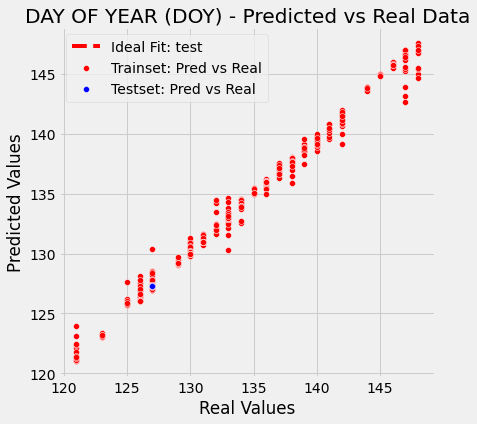

In [358]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example data
real_values = doy_label_test
predicted_values = doy_pred

# Create scatter plot
plt.figure(figsize=(6, 6))
sns.scatterplot(x=doy_label_train, y=doy_pred_training, label="Trainset: Pred vs Real", color="red")

sns.scatterplot(x=real_values, y=predicted_values, label="Testset: Pred vs Real", color="blue")

# Plot y=x line for reference
plt.plot(real_values, real_values, color="red", linestyle="--", label="Ideal Fit: test")

# Labels and title
plt.xlabel("Real Values")
plt.ylabel("Predicted Values")
plt.title("DAY OF YEAR (DOY) - Predicted vs Real Data")
plt.legend()

# Show plot
plt.show()

## RF - importance

      Feature  Importance
0        year    0.744050
4         ONI    0.128919
2       TOTAL    0.101395
3  ClimAdjust    0.014751
1       month    0.010885


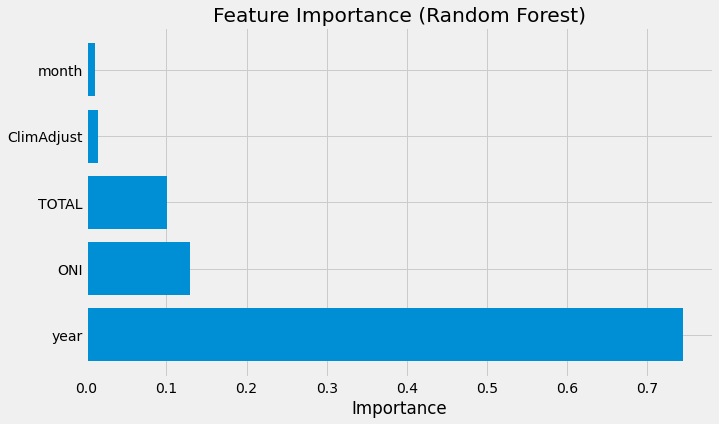

In [353]:
# Get the feature importances
importances = rf.feature_importances_

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({
    'Feature': input_features_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display the feature importances
print(feature_importance_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance (Random Forest)')
plt.show()

# LSTM try 1, failed

In [354]:
rnn = torch.nn.LSTM(10, 20, 2)
input = torch.randn(5, 3, 10)
h0 = torch.randn(2, 3, 20)
c0 = torch.randn(2, 3, 20)
output, (hn, cn) = rnn(input, (h0, c0))

In [355]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

In [356]:
# torch.tensor(input_features.values, dtype=torch.float32)
import torchvision.transforms as transforms
to_tensor_transform = transforms.Lambda(lambda x: torch.tensor(x.values, dtype=torch.float32))

# Apply the transform
tensor = to_tensor_transform(input_features)


# LSTM try 2, failed

In [332]:
lstm = nn.LSTM(10, 1)  # Input dim is 3, output dim is 3
inputs = tensor # torch.tensor(input_features.values, dtype=torch.float32) # input_features # [torch.randn(1, 3) for _ in range(5)]  # make a sequence of length 5
# doy_labels
# initialize the hidden state.
hidden = (torch.randn(1, 1, 1),
          torch.randn(1, 1, 1))

for i in inputs:
    # Step through the sequence one element at a time.
    # after each step, hidden contains the hidden state.
    out, hidden = lstm(i.view(1, 1, -1), hidden)

# alternatively, we can do the entire sequence all at once.
# the first value returned by LSTM is all of the hidden states throughout
# the sequence. the second is just the most recent hidden state
# (compare the last slice of "out" with "hidden" below, they are the same)
# The reason for this is that:
# "out" will give you access to all hidden states in the sequence
# "hidden" will allow you to continue the sequence and backpropagate,
# by passing it as an argument  to the lstm at a later time
# Add the extra 2nd dimension
inputs = torch.cat(inputs).view(len(inputs), 1, -1)
hidden = (torch.randn(1, 1, 1), torch.randn(1, 1, 1))  # clean out hidden state
out, hidden = lstm(inputs, hidden)
print(out)
print(hidden)

TypeError: cat(): argument 'tensors' (position 1) must be tuple of Tensors, not Tensor

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

df = pd.read_csv('airline-passengers.csv')
timeseries = df[["Passengers"]].values.astype('float32')

# train-test split for time series
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

train = 
test = 

def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

lookback = 4
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
# plot
plt.plot(timeseries)
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()

# LSTM try 3
* https://www.kaggle.com/code/purplejester/a-simple-lstm-based-time-series-classifier/notebook

In [690]:
doy_label_train.min(), doy_label_train.max()

(86, 109)

In [691]:
ID_COLS = ["month", "year", "year_month"] #  ["id"]
x_trn = input_features_train
y_trn = (doy_label_train-110)/(150-110) # normalise

x_tst = input_features_test
y_tst = (doy_label_test-110)/(150-110) # normalise

# tensor = torch.tensor(df.values, dtype=torch.float32)

In [692]:
x_trn.shape, y_trn.shape

((495, 6), (495,))

In [693]:
input_features_train

,year,month,TOTAL,ClimAdjust,year_month,ONI
0,1953,5,27.79,27.56,1953_5,0.2
1,1953,6,27.18,27.21,1953_6,0.0
2,1953,7,26.52,26.72,1953_7,-0.1
3,1953,8,26.30,26.30,1953_8,0.0
4,1953,9,26.35,26.14,1953_9,0.2
...,...,...,...,...,...,...
490,2016,9,28.92,26.72,2016_9,2.2
491,2016,10,29.07,26.72,2016_10,2.4
492,2016,11,29.41,26.70,2016_11,2.6
493,2016,12,29.26,26.60,2016_12,2.6


In [694]:
doy_label_train.min(), doy_label_train.max()

(86, 109)

In [695]:
x_trn.shape

(495, 6)

In [696]:
x_tst.shape

(45, 6)

In [697]:
doy_label_train.shape

(495,)

In [698]:
doy_label_test.shape

(45,)

In [699]:
np.mean([-1.62, -1.32, -1.07])
    

-1.336666666666667

In [700]:
if False: 
    pass
    doy_label_train == (y_trn * (150 - 110) + 110)

In [701]:
doy_label_train.shape

(495,)

In [702]:
x_trn.shape

(495, 6)

In [703]:
9*5

45

In [704]:
x_trn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 495 entries, 0 to 494
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   year        495 non-null    int64  
 1   month       495 non-null    int64  
 2   TOTAL       495 non-null    float64
 3   ClimAdjust  495 non-null    float64
 4   year_month  495 non-null    object 
 5   ONI         495 non-null    float64
dtypes: float64(3), int64(2), object(1)
memory usage: 27.1+ KB


In [705]:
#for arr in x_trn.iterrows():
    # print(arr)
    #arr = torch.tensor(x_trn.values, dtype=torch.float32)
    #print(torch.tensor(arr, dtype=torch.float32))

In [706]:
#x_trn.values
#[torch.tensor(arr, dtype=torch.float32) for arr in (x_trn.values, x_trn.values)][0][0:2]

In [707]:

#X_train, X_valid = [torch.tensor(arr, dtype=torch.float32) for arr in (x_trn, x_trn)]

## helper

In [708]:
def create_datasets_old(X, y, test_size=0.2, drop_cols=ID_COLS, time_dim_first=False):
    #enc = LabelEncoder()
    #y_enc = enc.fit_transform(y)
    
    # ONI data (batch_size=any, seq_length=9, input_dim=1)

    #enc = None
    
    X = create_grouped_array(X)
    
    #X_grouped = create_grouped_array(X)
    #if time_dim_first:
    #    X_grouped = X_grouped.transpose(0, 2, 1)
        
    #X = X.transpose(0, 2, 1) # this is not working with df i imagine, plus idk what order i need ...
    
    # X_train, X_valid, y_train, y_valid = train_test_split(X, y.to_list(), test_size=0.1)
    
    # valid = last 5 years
    X_train, X_valid = X[:-5*9], X[-5*9:]
    
    
    
    y_train, y_valid = y[:-5*9], y[-5*9:] 
    
    print(X_train)

    # torch.tensor(x_trn.values, dtype=torch.float32)
    
    X_train, X_valid = [torch.tensor(arr, dtype=torch.float32) for arr in (X_train.values, X_valid.values)]
    y_train, y_valid = [torch.tensor(arr, dtype=torch.float32) for arr in (y_train.values, y_valid.values)] # changed to float
    
    # get back to other code ...
    # TODO TODO TODO
    # the grouped thing should be done - i am currently taking 9 features of length one instead of 1 feature (ONI) with length 9 (aka 9 months)
    
    train_ds = TensorDataset(X_train, y_train)
    valid_ds = TensorDataset(X_valid, y_valid)
    return train_ds, valid_ds, None


def create_datasets(X, y, test_size=0.2, drop_cols=ID_COLS, time_dim_first=False):
    #enc = LabelEncoder()
    #y_enc = enc.fit_transform(y)
    X_grouped = create_grouped_array(X)
    if time_dim_first:
        X_grouped = X_grouped.transpose(0, 2, 1)
        
    #X_train, X_valid, y_train, y_valid = train_test_split(X_grouped, y, test_size=0.1)
    #X_train, X_valid = [torch.tensor(arr, dtype=torch.float32) for arr in (X_train, X_valid)]
    #y_train, y_valid = [torch.tensor(arr, dtype=torch.long) for arr in (y_train, y_valid)]
    
    print("is it correct here?", X.shape, y.shape)
    print("is it correct here?", X_grouped.shape, y.shape)
    
    X_train, X_valid = X_grouped[:-5], X_grouped[-5:]
    
    # drop all but every ninth value
    y = y.iloc[::9]
    y_train, y_valid = y[:-5], y[-5:] 
    
    print("is it correct here?", X_train.shape, y_train.shape)
    
    #print(X)
    #print(X_train)
    
    # print(y_train)
    
    #X_train, X_valid = [torch.tensor(arr, dtype=torch.float32) for arr in (X_train.values, X_valid.values)]
    y_train, y_valid = [torch.tensor(arr, dtype=torch.float32) for arr in (y_train.values, y_valid.values)]
    
    X_train, X_valid = [torch.tensor(arr, dtype=torch.float32) for arr in (X_train, X_valid)]
    # y_train, y_valid = [torch.tensor(arr, dtype=torch.long) for arr in (y_train, y_valid)]
    
    
    
    train_ds = TensorDataset(X_train, y_train)
    valid_ds = TensorDataset(X_valid, y_valid)
    return train_ds, valid_ds, None


def create_grouped_array(data, group_col='year', drop_cols=ID_COLS):
    X_grouped = np.row_stack([
        group.drop(columns=drop_cols).values[None]
        for _, group in data.groupby(group_col)])
    return X_grouped


def create_test_dataset(X, drop_cols=ID_COLS):
    X_grouped = np.row_stack([
        group.drop(columns=drop_cols).values[None]
        for _, group in X.groupby('year')])
    X_grouped = torch.tensor(X_grouped.transpose(0, 2, 1)).float()
    y_fake = torch.tensor([0] * len(X_grouped)).long()
    return TensorDataset(X_grouped, y_fake)


def create_loaders(train_ds, valid_ds, bs=512, jobs=0):
    train_dl = DataLoader(train_ds, bs, shuffle=True, num_workers=jobs)
    valid_dl = DataLoader(valid_ds, bs, shuffle=False, num_workers=jobs)
    return train_dl, valid_dl


def accuracy(output, target):
    return (output.argmax(dim=1) == target).float().mean().item()

In [709]:
class CyclicLR(_LRScheduler):
    
    def __init__(self, optimizer, schedule, last_epoch=-1):
        assert callable(schedule)
        self.schedule = schedule
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        return [self.schedule(self.last_epoch, lr) for lr in self.base_lrs]

In [710]:
def cosine(t_max, eta_min=0):
    
    def scheduler(epoch, base_lr):
        t = epoch % t_max
        return eta_min + (base_lr - eta_min)*(1 + np.cos(np.pi*t/t_max))/2
    
    return scheduler

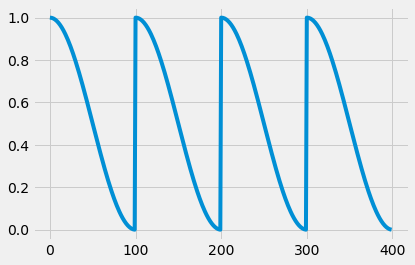

In [711]:
n = 100
sched = cosine(n)
lrs = [sched(t, 1) for t in range(n * 4)]
plt.plot(lrs)


In [712]:
class LSTMClassifier(nn.Module):
    """Very simple implementation of LSTM-based time-series classifier."""
    
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        
        # (batch_size, seq_length, input_size) # 4, 1, 10
        self.rnn = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True) # why is it 1???
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.batch_size = None
        self.hidden = None
    
    def forward(self, x):
        h0, c0 = self.init_hidden(x)
        
        #print("x", x.shape)
        
        out, (hn, cn) = self.rnn(x, (h0, c0))
        
        #print("out.shape", out.shape)
        #print("out[:, -1, :].shape", out[:, -1, :].shape)
        #print("out[0:2, 0, 0:4]", out[0:2, 0, 0:4])
        
        out = self.fc(out[:, -1, :]) # out[:, -1, :])
        
        #print("after fc out", out)
        
        return out
    
    def init_hidden(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        return [t.cuda() for t in (h0, c0)]

In [713]:
x_trn.shape, y_trn.shape

((495, 6), (495,))

In [714]:
print('Preparing datasets')
trn_ds, val_ds, enc = create_datasets(x_trn, y_trn)

Preparing datasets
is it correct here? (495, 6) (495,)
is it correct here? (55, 9, 3) (495,)
is it correct here? (50, 9, 3) (50,)


In [715]:
495/55

9.0

In [716]:
bs = 8 # must be less than 70, cause we only have 70 years ...
print(f'Creating data loaders with batch size: {bs}')
trn_dl, val_dl = create_loaders(trn_ds, val_ds, bs)

Creating data loaders with batch size: 8


In [717]:
input_dim = 3 # features per time step - ONI = 1
hidden_dim = 256
layer_dim = 3
output_dim = 1
seq_dim = bs # amount of months - this is how many time steps in one feature

# Dummy EEG data (batch_size=100, seq_length=50, input_dim=10)
# X = torch.randn(100, 50, 10)  # (100 samples, 50 time steps, 10 features per time step)

lr = 0.0005
n_epochs = 50000
iterations_per_epoch = len(trn_dl)
best_mse = 1000
patience, trials = 200, 0

model = LSTMClassifier(input_dim, hidden_dim, layer_dim, output_dim)
model = model.cuda()
criterion = nn.MSELoss() # replaced cross entropy
opt = torch.optim.RMSprop(model.parameters(), lr=lr)
sched = CyclicLR(opt, cosine(t_max=iterations_per_epoch * 2, eta_min=lr/100))

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print('Start model training')

for epoch in range(1, n_epochs + 1):
    
    print("* train *"*40)
    
    for i, (x_batch, y_batch) in enumerate(trn_dl):
        
        
        
        model.train()
        x_batch = x_batch.cuda()
        y_batch = y_batch.cuda()
        
        #print("x_batch", x_batch)
        #print("y_batch", y_batch)
        
        
        
        opt.zero_grad()
        out = model(x_batch)
        
        loss = criterion(out, y_batch.unsqueeze(1))
        loss.backward()
        opt.step()
        
        sched.step()
        
        if i == 0:
            print("preds", out)
            print("y_batch", y_batch)
            print("loss", loss)
        
        
    
        
    
    model.eval()
    with torch.no_grad():
        print("* val *"*40)
        
        correct, total = 0, 0
        for x_val, y_val in val_dl:
            x_val, y_val = [t.cuda() for t in (x_val, y_val)]
            out = model(x_val)
            # preds = F.log_softmax(out, dim=1).argmax(dim=1) # NOT GOOD ...
            # preds = out

            # correct += (preds == y_val).sum().item()

            total += 1#  y_val.size(0)
            #print(out.detach().cpu().numpy())
            #print(y_val.detach().cpu().numpy())
            correct += mean_squared_error(out.detach().cpu().numpy(), y_val.detach().cpu().numpy())
        
    #print(correct)
    mse = correct / total

    
    if epoch % 5 == 0:
        
        print(f'Epoch: {epoch:3d}. Loss: {loss.item():.4f}. mean_squared_error.: {mse}')

    
    if mse > best_mse:
        trials = 0
        best_acc = acc
        # torch.save(model.state_dict(), 'best.pth')
        print(f'Epoch {epoch} best model saved with accuracy: {best_acc:2.2%}')
    else:
        trials += 1
        if trials >= patience:
            print(f'Early stopping on epoch {epoch}')
            break
    
            
print("Done")

Start model training
* train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train ** train *
preds tensor([[-0.0534],
        [-0.0543],
        [-0.0537],
        [-0.0537],
        [-0.0541],
        [-0.0540],
        [-0.0542],
        [-0.0541]], device='cuda:0', grad_fn=<AddmmBackward0>)
y_batch tensor([-0.5000, -0.3500, -0.2000, -0.4250, -0.5250, -0.4500, -0.4000, -0.5000],
       device='cuda:0')
loss tensor(0.1429, device='cuda:0', grad_fn=<MseLossBackward0>)
* val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val ** val *

In [718]:
r2_score([234, 231, 932], [234, 443, 123])

-1.1441293502851995

In [719]:
mean_squared_error([234], [239])

25.0

In [720]:
model.eval()

LSTMClassifier(
  (rnn): LSTM(3, 256, num_layers=3, batch_first=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)

In [721]:
test_dl = DataLoader(create_test_dataset(x_tst), batch_size=1, shuffle=False)

In [722]:
test = []
print('Predicting on test dataset')
for batch, _ in test_dl:
    batch = batch.permute(0, 2, 1)
    print("feature 1-3")
    print(batch)
    out = model(batch.cuda())
    print("out", out)
    # y_hat = F.log_softmax(out, dim=1).argmax(dim=1)
    test += out.tolist()

Predicting on test dataset
feature 1-3
tensor([[[28.2400, 27.9400,  0.4000],
         [27.7000, 27.7300, -0.1000],
         [26.8200, 27.2900, -0.4000],
         [26.2800, 26.8600, -0.5000],
         [26.1500, 26.7200, -0.6000],
         [25.9800, 26.7200, -0.7000],
         [25.9500, 26.7000, -0.7000],
         [26.1000, 26.6000, -0.6000],
         [26.1200, 26.5500, -0.3000]]])
out tensor([[-0.3408]], device='cuda:0', grad_fn=<AddmmBackward0>)
feature 1-3
tensor([[[28.3000, 27.9400,  0.3000],
         [28.0600, 27.7300,  0.3000],
         [27.5400, 27.2900,  0.1000],
         [26.7000, 26.8600, -0.1000],
         [26.2900, 26.7200, -0.4000],
         [26.1500, 26.7200, -0.7000],
         [25.7400, 26.7000, -0.8000],
         [25.6200, 26.6000, -1.0000],
         [25.5700, 26.5500, -0.9000]]])
out tensor([[-0.3356]], device='cuda:0', grad_fn=<AddmmBackward0>)
feature 1-3
tensor([[[27.7400, 27.9400, -0.2000],
         [27.7700, 27.7300,  0.0000],
         [27.4200, 27.2900,  0.1000],
 

In [723]:
test

[[-0.34079355001449585],
 [-0.33558881282806396],
 [-0.3457620143890381],
 [-0.34279853105545044],
 [-0.3380947709083557]]

In [724]:
[(y[0] * (150 - 110) + 110) for y in test]

[96.36825799942017,
 96.57644748687744,
 96.16951942443848,
 96.28805875778198,
 96.47620916366577]

In [725]:
y_tst[::9]

495   -0.375
504   -0.550
513   -0.425
522   -0.475
531   -0.650
Name: doy_cherry_peak_bloom, dtype: float64

In [726]:
y_tst[::9] * (150 - 110) + 110

495    95.0
504    88.0
513    93.0
522    91.0
531    84.0
Name: doy_cherry_peak_bloom, dtype: float64

## LSTM try 3 - plots

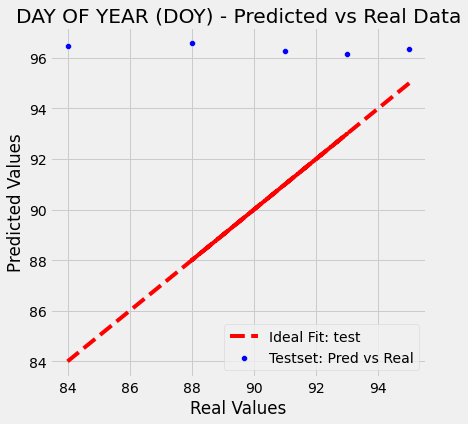

In [758]:
import matplotlib.pyplot as plt
import seaborn as sns

# Data
real_values = y_tst[::9] * (150 - 110) + 110
predicted_values = [(y[0] * (150 - 110) + 110) for y in test]

# Create scatter plot
plt.figure(figsize=(6, 6))
#sns.scatterplot(x=doy_label_train, y=doy_pred_training, label="Trainset: Pred vs Real", color="red")
sns.scatterplot(x=real_values, y=predicted_values, label="Testset: Pred vs Real", color="blue")

# Plot y=x line for reference
plt.plot(real_values, real_values, color="red", linestyle="--", label="Ideal Fit: test")

# Labels and title
plt.xlabel("Real Values")
plt.ylabel("Predicted Values")
plt.title("DAY OF YEAR (DOY) - Predicted vs Real Data")
plt.legend()

# Show plot
plt.show()

# RNN try, failed ********** ********** **********

In [ ]:
class BasicRNN(nn.Module):
    def __init__(self, n_inputs, n_neurons):
        super(BasicRNN, self).__init__()
        
        self.Wx = torch.randn(n_inputs, n_neurons) # n_inputs X n_neurons
        self.Wy = torch.randn(n_neurons, n_neurons) # n_neurons X n_neurons
        
        self.b = torch.zeros(1, n_neurons) # 1 X n_neurons
    
    def forward(self, X0, X1):
        self.Y0 = torch.tanh(torch.mm(X0, self.Wx) + self.b) # batch_size X n_neurons
        
        self.Y1 = torch.tanh(torch.mm(self.Y0, self.Wy) +
                            torch.mm(X1, self.Wx) + self.b) # batch_size X n_neurons
        
        return self.Y0, self.Y1

In [ ]:
N_INPUT = 3 # number of features in input
N_NEURONS = 5 # number of units in layer

X0_batch = torch.tensor([[0,1,2], [3,4,5], 
                         [6,7,8], [9,0,1]],
                        dtype = torch.float) #t=0 => 4 X 3

X1_batch = torch.tensor([[9,8,7], [0,0,0], 
                         [6,5,4], [3,2,1]],
                        dtype = torch.float) #t=1 => 4 X 3

model = BasicRNN(N_INPUT, N_NEURONS)

Y0_val, Y1_val = model(X0_batch, X1_batch)

In [ ]:
print(Y0_val)
print(Y1_val)

# random

In [ ]:
import pandas as pd

# Example dataframe
data = {
    "year": [1953, 1954],
    "ONI_AMJ_prev": [0.2, 0.8], "ONI_MJJ_prev": [0.0, 0.8], "ONI_JJA_prev": [-0.1, 0.7], 
    "ONI_JAS_prev": [0.0, 0.7], "ONI_ASO_prev": [0.2, 0.8], "ONI_SON_prev": [0.1, 0.8], 
    "ONI_OND_prev": [0.0, 0.8], "ONI_NDJ_prev": [0.1, 0.8], "ONI_DJF": [0.4, 0.8]
}
df = pd.DataFrame(data)

# Define a mapping of seasons to actual month numbers
season_to_month = {
    "AMJ_prev": 5, "MJJ_prev": 6, "JJA_prev": 7, "JAS_prev": 8, "ASO_prev": 9, 
    "SON_prev": 10, "OND_prev": 11, "NDJ_prev": 12, "DJF": 13
}

# Convert to long format
df_long = df.melt(id_vars=["year"], var_name="season", value_name="ONI")

# Extract season key (e.g., AMJ_prev, MJJ_prev, DJF)
df_long["season_key"] = df_long["season"].str.replace("ONI_", "")

# Map to actual months
df_long["month"] = df_long["season_key"].map(season_to_month)

# Create year-month column
df_long["year_month"] = df_long["year"].astype(str) + "_" + df_long["month"].astype(str)

# Keep only required columns
df_long = df_long[["year", "month", "ONI", "year_month"]]

df_long = df_long.sort_values(["year", "month"])

print(df_long)

In [ ]:
# Define a mapping of seasons to actual month numbers
season_to_month = {
    "AMJ_prev": 5, "MJJ_prev": 6, "JJA_prev": 7, "JAS_prev": 8, "ASO_prev": 9, 
    "SON_prev": 10, "OND_prev": 11, "NDJ_prev": 12, "DJF": 13
}


# Convert to long format
x_trn = x_trn.melt(id_vars=["year"], var_name="season", value_name="ONI")

# Extract season key (e.g., AMJ_prev, MJJ_prev, DJF)
x_trn["season_key"] = x_trn["season"].str.replace("ONI_", "")

# Map to actual months
x_trn["month"] = x_trn["season_key"].map(season_to_month)

# Create year-month column
x_trn["year_month"] = x_trn["year"].astype(str) + "_" + x_trn["month"].astype(str)

# Keep only required columns
x_trn = x_trn[["year", "month", "ONI", "year_month"]]

x_trn = x_trn.sort_values(["year", "month"])

x_trn.head()

In [ ]:
# Define a mapping of seasons to actual month numbers
season_to_month = {
    "AMJ_prev": 5, "MJJ_prev": 6, "JJA_prev": 7, "JAS_prev": 8, "ASO_prev": 9, 
    "SON_prev": 10, "OND_prev": 11, "NDJ_prev": 12, "DJF": 13
}


# Convert to long format
x_tst = x_tst.melt(id_vars=["year"], var_name="season", value_name="ONI")

# Extract season key (e.g., AMJ_prev, MJJ_prev, DJF)
x_tst["season_key"] = x_tst["season"].str.replace("ONI_", "")

# Map to actual months
x_tst["month"] = x_tst["season_key"].map(season_to_month)

# Create year-month column
x_tst["year_month"] = x_tst["year"].astype(str) + "_" + x_tst["month"].astype(str)

# Keep only required columns
x_tst = x_tst[["year", "month", "ONI", "year_month"]]

x_tst = x_tst.sort_values(["year", "month"])

x_tst